In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
import time
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from datetime import timedelta
from tensorflow.keras.preprocessing import image

In [ ]:
input_shape = (32, 32, 3)
num_classes = 10

### Preprocessing

In [4]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# scale images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# one-hot encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

### Report and Plot Function for All models

In [ ]:
# Store training times
times = []

def report_n_plot(model_name, history, model, x_test, y_test_cat, start_time, end_time):
    # Record training time and print for each experiment
    train_time = (end_time - start_time) / 60
    times.append(train_time)

    minutes, seconds = divmod(int(end_time - start_time), 60)
    print(f"\n{model_name}")
    print(f"Training completed in {minutes} minutes and {seconds} seconds")

    # Final training/val accuracy
    print(f"Training Accuracy:   {history.history['accuracy'][-1]:.4f}")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    # Test accuracy
    test_loss, test_accuracy = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Plot accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, '--', color='green', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, '--', color='green', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, max(max(loss), max(val_loss)) * 1.1)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### Experiment 1 - Baseline Model (Model 1)

In [ ]:
# build model
model_1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# model compile
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_1 = time.time()
# train the model
history_1 = model_1.fit(x_train, y_train_cat, epochs=40, batch_size=32, validation_split=0.2, verbose=0)
end_1 = time.time()


Baseline Model
Training completed in 1 minutes and 52 seconds
Training Accuracy:   0.9592
Validation Accuracy: 0.6483
Test Accuracy: 0.6452


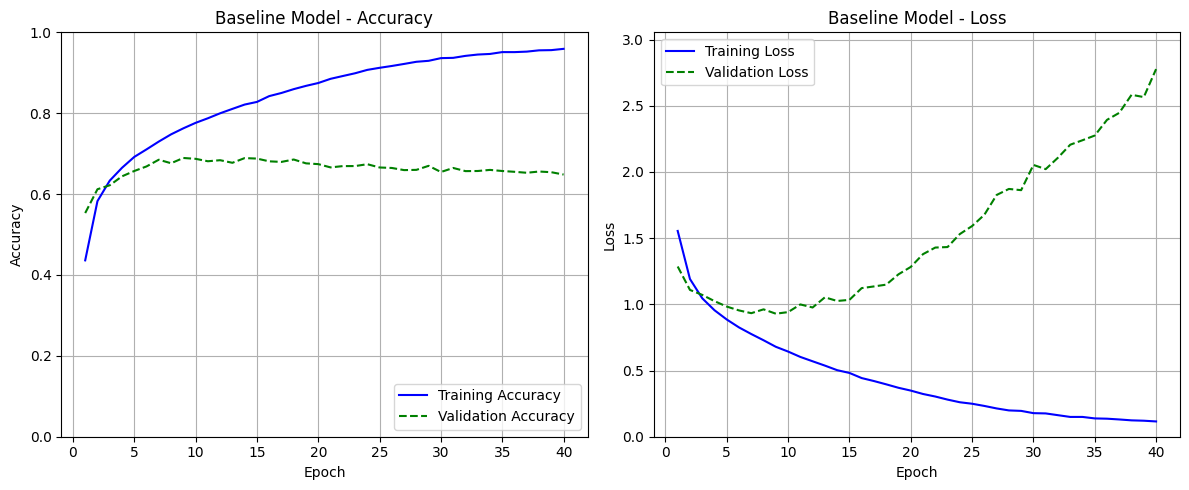

In [ ]:
# call report_n_plot function to show all results
report_n_plot(
    model_name="Baseline Model",
    history=history_1,
    model=model_1,
    x_test=x_test,
    y_test_cat=y_test_cat,
    start_time=start_1,
    end_time=end_1
)

### Experiment 2 - CNN with BatchNorm + Dropout (Model 2)

In [ ]:
# build model
model_2 = keras.Sequential([
    keras.Input(shape=input_shape),

    layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax"),
])

# compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_2 = time.time()
# train the model
history_2 = model_2.fit(x_train, y_train_cat, epochs=40, batch_size=32, validation_split=0.2, verbose=0)
end_2 = time.time()




CNN with Batch Normalisation and Dropout
Training completed in 2 minutes and 31 seconds
Training Accuracy:   0.8300
Validation Accuracy: 0.7373
Test Accuracy: 0.7373


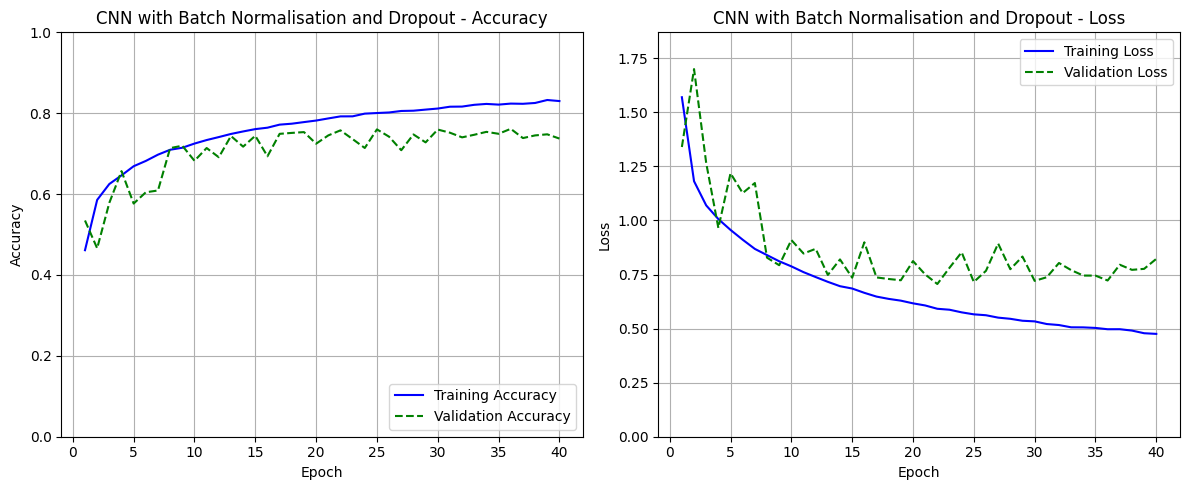

In [ ]:
# call report_n_plot function to show all results
report_n_plot(
    model_name="CNN with Batch Normalisation and Dropout",
    history=history_2,
    model=model_2,
    x_test=x_test,
    y_test_cat=y_test_cat,
    start_time=start_2,
    end_time=end_2
)

### Experiment 3 - Two conv blocks with batch normalisation and dropout without augmentation (Model 3)

In [ ]:
# Split training/validation
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train_cat, test_size=0.2, random_state=42
)

# Build model
def model(input_shape, num_classes):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Initialize and compile
model_3 = model(input_shape=input_shape, num_classes=num_classes)
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


start_3 = time.time()

# Train the model without data augmentation
history_3 = model_3.fit(
    x_train_split, y_train_split,
    epochs=40,
    batch_size=32,
    validation_data=(x_val_split, y_val_split),
    verbose=0
)

end_3 = time.time()



TwoConv Deep CNN with No Aug
Training completed in 4 minutes and 33 seconds
Training Accuracy:   0.9151
Validation Accuracy: 0.8180
Test Accuracy: 0.8171


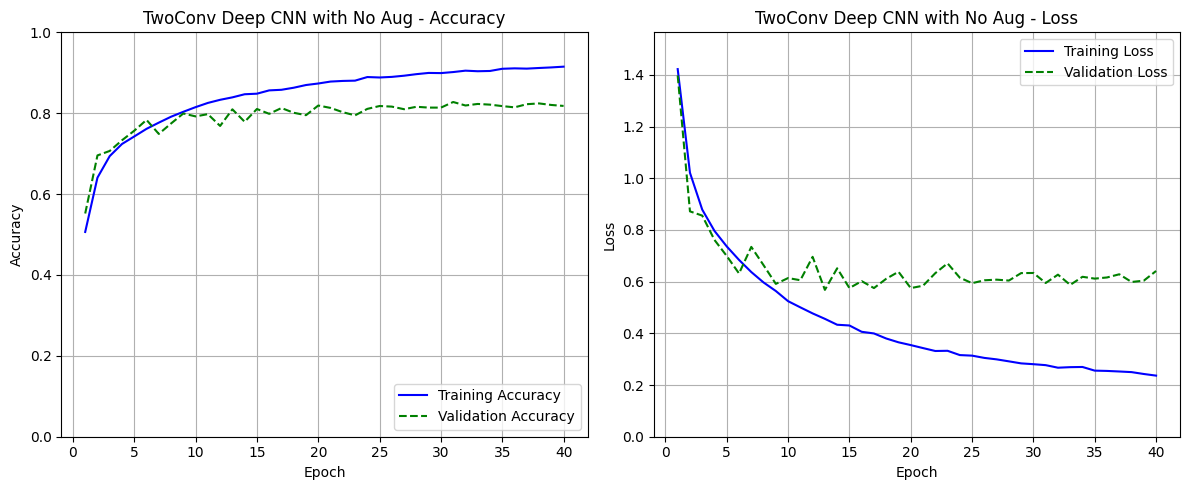

In [ ]:
# call report_n_plot function to show all results
report_n_plot(
    model_name="TwoConv Deep CNN with No Aug",
    history=history_3,
    model=model_3,
    x_test=x_test,
    y_test_cat=y_test_cat,
    start_time=start_3,
    end_time=end_3
)

### Experiment 4 - Two conv blocks with batch normalisation and dropout with augmentation (Model 4)

In [13]:
# Data augmentation and rescaling for training
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.02,
    height_shift_range=0.05,
    width_shift_range=0.05,
)

val_datagen = ImageDataGenerator()
# Create generators
train_generator = train_datagen.flow(x_train_split, y_train_split, batch_size=32)
val_generator = val_datagen.flow(x_val_split, y_val_split, batch_size=32)

model_4 = model(input_shape=input_shape, num_classes=num_classes)
# Compile the model
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_4 = time.time()
# Train the model with data augmentation
history_4 = model_4.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    batch_size=32,
    verbose=0,
)
end_4 = time.time()


TwoConv Deep CNN With Aug
Training completed in 6 minutes and 16 seconds
Training Accuracy:   0.8388
Validation Accuracy: 0.8246
Test Accuracy: 0.8234


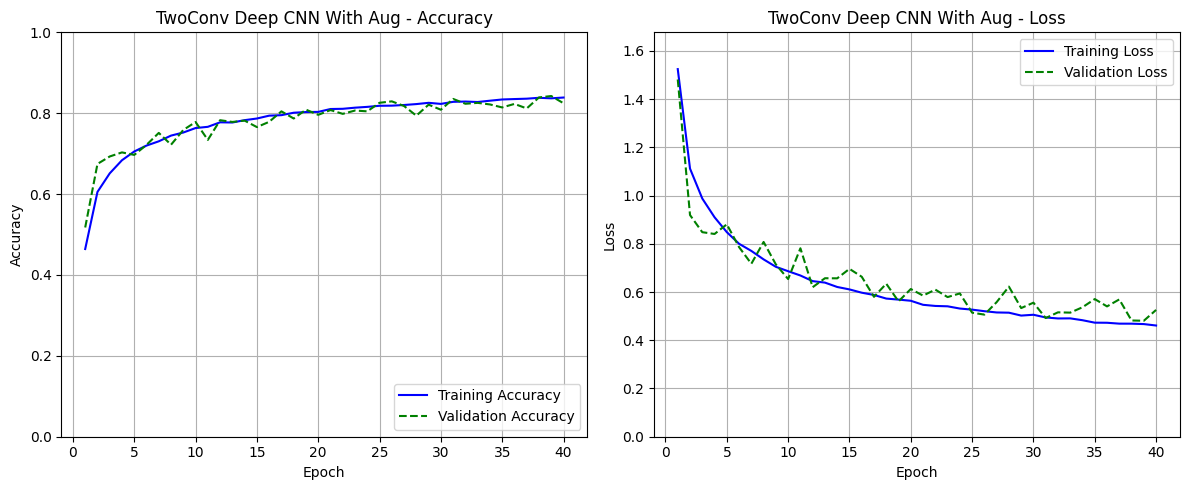

In [ ]:
# call report_n_plot function to show all results
report_n_plot(
    model_name="TwoConv Deep CNN With Aug",
    history=history_4,
    model=model_4,
    x_test=x_test,
    y_test_cat=y_test_cat,
    start_time=start_4,
    end_time=end_4
)

### Experiment 5 - Hyperparameter_Tuned CNN (Model 5)

In [ ]:

# Hypermodel
def model_hp(hp):
    model = models.Sequential()
    
    # Block 1
    model.add(layers.Conv2D(hp.Int('conv1', 32, 64, 16), 3, padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(hp.Int('conv2', 32, 64, 16), 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(hp.Float('dropout_1', 0.2, 0.5, 0.1)))

    # Block 2
    model.add(layers.Conv2D(hp.Int('conv3', 64, 128, 32), 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(hp.Int('conv4', 64, 128, 32), 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(hp.Float('dropout_2', 0.2, 0.5, 0.1)))

    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense', 64, 256, 64), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_dense', 0.2, 0.5, 0.1)))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model 
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

    return model

# Tuner setup
tuner = kt.Hyperband(
    model_hp, objective='val_accuracy', max_epochs=40, factor=3,
    directory='hyperband_dir', project_name='exp5_hyper'
)

# Tuning
start_5 = time.time()
tuner.search(train_generator, epochs=40, validation_data=val_generator, verbose=1)

# Get best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

# Final training
model_5 = tuner.get_best_models(1)[0]
history_5 = model_5.fit(train_generator, epochs=40, batch_size=32, validation_data=val_generator, verbose=1)
end_5 = time.time()

Trial 90 Complete [00h 06m 56s]
val_accuracy: 0.8370000123977661

Best val_accuracy So Far: 0.8632000088691711
Total elapsed time: 02h 24m 24s
Epoch 1/40
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2752 - accuracy: 0.9015 - val_loss: 0.4401 - val_accuracy: 0.8619
Epoch 2/40
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2652 - accuracy: 0.9069 - val_loss: 0.5032 - val_accuracy: 0.8423
Epoch 3/40
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2614 - accuracy: 0.9093 - val_loss: 0.4608 - val_accuracy: 0.8583
Epoch 4/40
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2602 - accuracy: 0.9082 - val_loss: 0.4504 - val_accuracy: 0.8576
Epoch 5/40
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2529 - accuracy: 0.9104 - val_loss: 0.4483 - val_accuracy: 0.8618
Epoch 6/40
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2512 - accuracy: 0.9100 - val_loss: 0.4758 - va

Results

Best hyperparameters: 
conv1          : 64
conv2          : 64
dropout_1      : 0.2
conv3          : 96
conv4          : 128
dropout_2      : 0.4
dense          : 256
dropout_dense  : 0.2
learning_rate  : 0.0010463766655229093
tuner/epochs   : 40
tuner/initial_epoch: 0
tuner/bracket  : 0
tuner/round    : 0


Hyperparameter-Tuned CNN
Training completed in 153 minutes and 34 seconds
Training Accuracy:   0.9394
Validation Accuracy: 0.8772
Test Accuracy: 0.8721


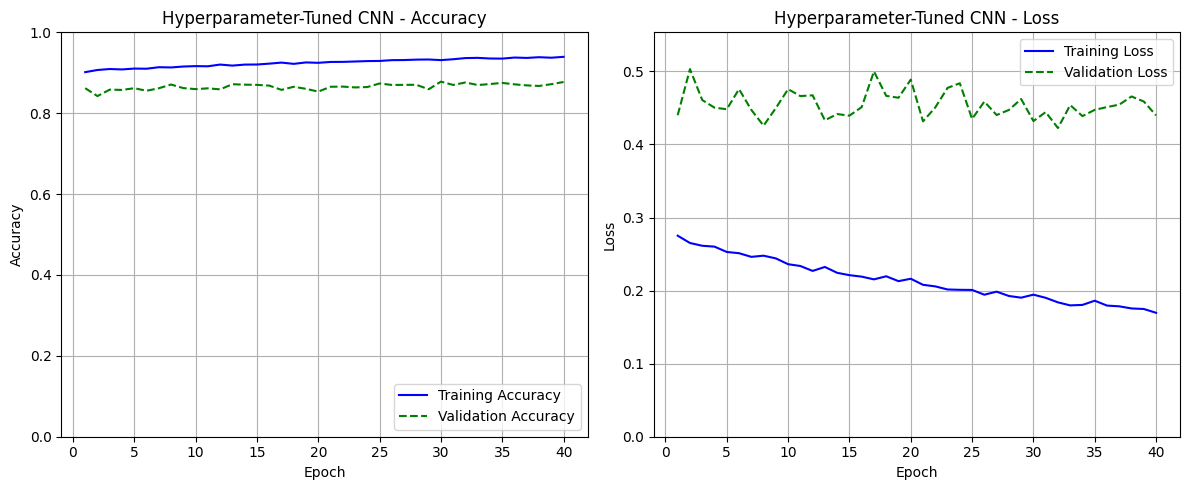

In [ ]:

# Print best hyperparameters
print("Best hyperparameters: ")
for hp_name in best_hp.values.keys():
    print(f"{hp_name:15}: {best_hp.get(hp_name)}")

print()

# call report_n_plot function to show all results
report_n_plot(
    model_name="Hyperparameter-Tuned CNN",
    history=history_5,
    model=model_5,
    x_test=x_test,
    y_test_cat=y_test_cat,
    start_time=start_5,
    end_time=end_5
)

### Experiment 6 - Best hyperparameters Model (Model 6)

In [ ]:


# build model
def final_model(input_shape, num_classes):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(best_hp.get('conv1'), 3, padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(best_hp.get('conv2'), 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(best_hp.get('dropout_1')))

    # Block 2
    model.add(layers.Conv2D(best_hp.get('conv3'), 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(best_hp.get('conv4'), 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(best_hp.get('dropout_2')))

    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(best_hp.get('dense'), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(best_hp.get('dropout_dense')))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model_6 = final_model(input_shape=input_shape, num_classes=num_classes)

# Compile the model
model_6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get('learning_rate')),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

start_6 = time.time()
# Train the model with data augmentation
history_6 = model_6.fit(train_generator, epochs=40, validation_data=val_generator, batch_size=32, verbose=0,)
end_6 = time.time()

Results


Best Hyper-parameters
Training completed in 8 minutes and 40 seconds
Training Accuracy:   0.9122
Validation Accuracy: 0.8751
Test Accuracy: 0.8649


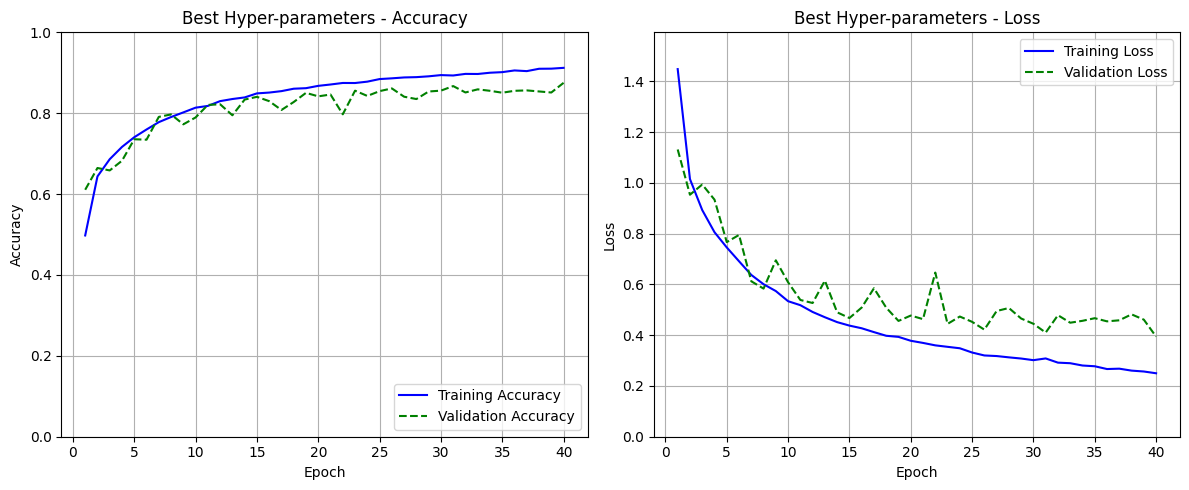

In [ ]:
# call report_n_plot function to show all results
report_n_plot(
    model_name="Best Hyper-parameters",
    history=history_6,
    model=model_6,
    x_test=x_test,
    y_test_cat=y_test_cat,
    start_time=start_6,
    end_time=end_6,
)

### Compare All Experiments – Training Accuracy Plots

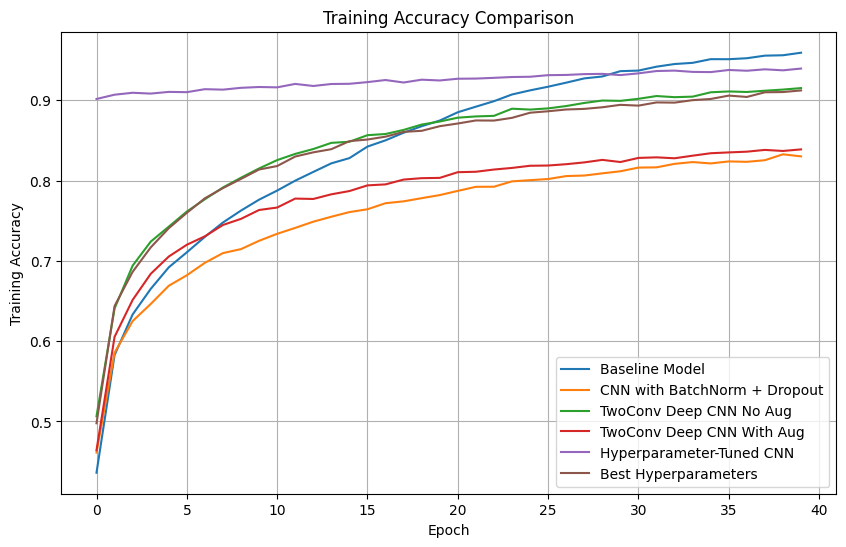

In [ ]:
# a function to plot Training Accuracy
def plot_accuracies(histories, labels):
    plt.figure(figsize=(10, 6))
    for h, l in zip(histories, labels):
        plt.plot(h.history['accuracy'], label=f'{l}')
    plt.title("Training Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with labeling
plot_accuracies(
    [history_1, history_2, history_3, history_4, history_5, history_6],
    ['Baseline Model', 'CNN with BatchNorm + Dropout', 'TwoConv Deep CNN No Aug', 'TwoConv Deep CNN With Aug', 'Hyperparameter-Tuned CNN', 'Best Hyperparameters']
)

### Compare All Experiments – Validation Accuracy Plots

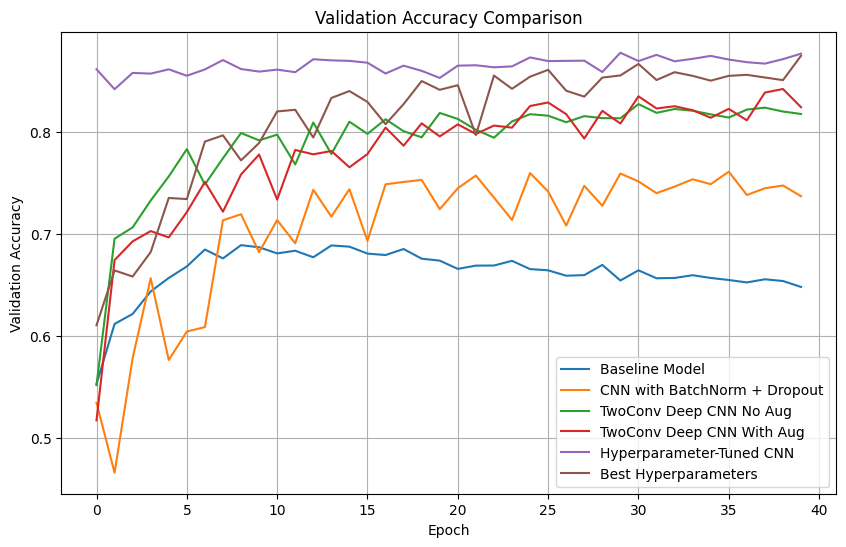

In [ ]:
# a function to plot validation accuracy
def plot_accuracies(histories, labels):
    plt.figure(figsize=(10, 6))
    for h, l in zip(histories, labels):
        plt.plot(h.history['val_accuracy'], label=f'{l}')
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with labeling
plot_accuracies(
    [history_1, history_2, history_3, history_4, history_5, history_6],
    ['Baseline Model', 'CNN with BatchNorm + Dropout', 'TwoConv Deep CNN No Aug', 'TwoConv Deep CNN With Aug', 'Hyperparameter-Tuned CNN', 'Best Hyperparameters']
)

### Summary Table

In [ ]:

# these variables for comparison
histories = [history_1, history_2, history_3, history_4, history_5, history_6]
models = [model_1, model_2, model_3, model_4, model_5, model_6]
names = ['Baseline Model', 'CNN with BatchNorm + Dropout', 'TwoConv Deep CNN No Aug', 'TwoConv Deep CNN With Aug', 'Hyperparameter-Tuned CNN', 'Best Hyperparameters']

# training times convert "mm:ss" format
training_times = times
training_seconds = [round(m * 60) for m in training_times]
formatted_times = [str(timedelta(seconds=sec)) for sec in training_seconds]

# training and validation accuracies
train_accuracies = [max(h.history['accuracy']) for h in histories]
val_accuracies = [max(h.history['val_accuracy']) for h in histories]

# test accuracies
test_accuracies = [model.evaluate(x_test, y_test_cat, verbose=0)[1] for model in models]

# Create DataFrame
df = pd.DataFrame({
    "Experiment": names,
    "Time": formatted_times,
    "Train Acc": train_accuracies,
    "Val Acc": val_accuracies,
    "Test Acc": test_accuracies,
})

print(df)


                     Experiment     Time  Train Acc  Val Acc  Test Acc
0                Baseline Model  0:01:53   0.959150   0.6893    0.6452
1  CNN with BatchNorm + Dropout  0:02:31   0.832650   0.7614    0.7373
2       TwoConv Deep CNN No Aug  0:04:34   0.915100   0.8277    0.8171
3     TwoConv Deep CNN With Aug  0:06:16   0.838775   0.8425    0.8234
4      Hyperparameter-Tuned CNN  2:33:34   0.939425   0.8781    0.8721
5          Best Hyperparameters  0:08:40   0.912175   0.8751    0.8649


### To Generate Confucsion Matrix and Classification Report for All Models

313/313 [==============================] - 1s 2ms/step


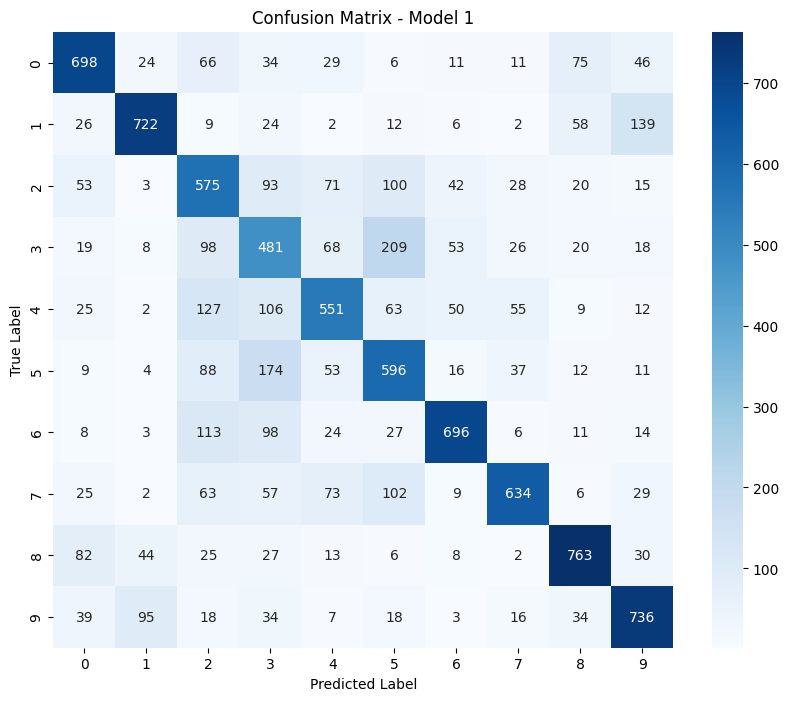

Classification Report - Model 1
              precision    recall  f1-score   support

    Airplane       0.71      0.70      0.70      1000
  Automobile       0.80      0.72      0.76      1000
        Bird       0.49      0.57      0.53      1000
         Cat       0.43      0.48      0.45      1000
        Deer       0.62      0.55      0.58      1000
         Dog       0.52      0.60      0.56      1000
        Frog       0.78      0.70      0.73      1000
       Horse       0.78      0.63      0.70      1000
        Ship       0.76      0.76      0.76      1000
       Truck       0.70      0.74      0.72      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000

--------------------------------------------------------------------------------
313/313 [==============================] - 0s 869us/step


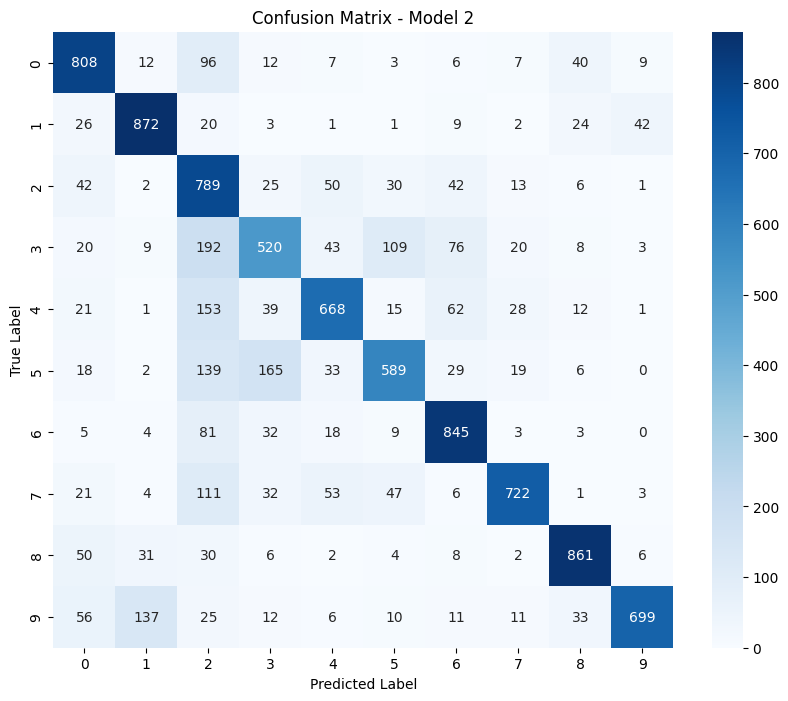

Classification Report - Model 2
              precision    recall  f1-score   support

    Airplane       0.76      0.81      0.78      1000
  Automobile       0.81      0.87      0.84      1000
        Bird       0.48      0.79      0.60      1000
         Cat       0.61      0.52      0.56      1000
        Deer       0.76      0.67      0.71      1000
         Dog       0.72      0.59      0.65      1000
        Frog       0.77      0.84      0.81      1000
       Horse       0.87      0.72      0.79      1000
        Ship       0.87      0.86      0.86      1000
       Truck       0.91      0.70      0.79      1000

    accuracy                           0.74     10000
   macro avg       0.76      0.74      0.74     10000
weighted avg       0.76      0.74      0.74     10000

--------------------------------------------------------------------------------
313/313 [==============================] - 0s 1ms/step


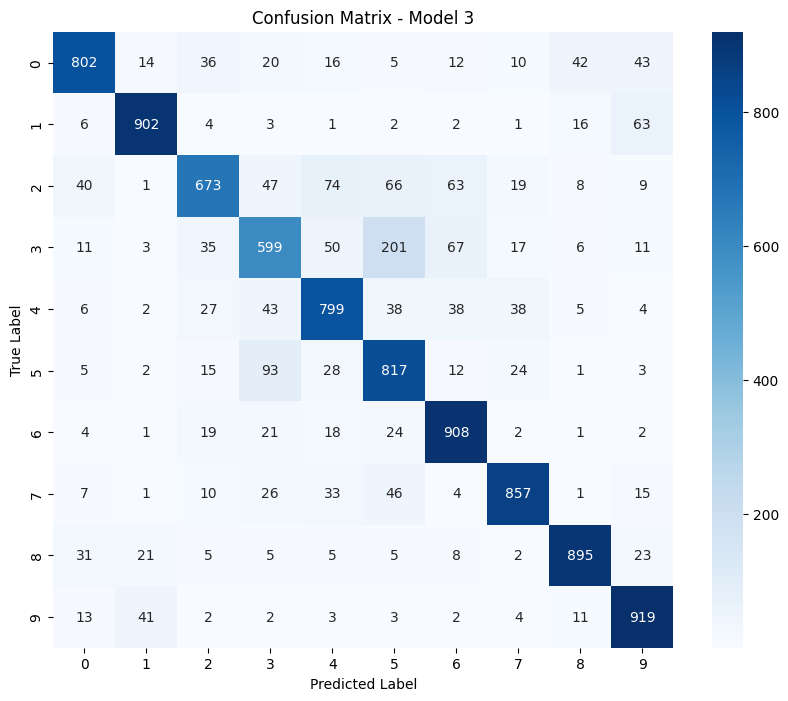

Classification Report - Model 3
              precision    recall  f1-score   support

    Airplane       0.87      0.80      0.83      1000
  Automobile       0.91      0.90      0.91      1000
        Bird       0.81      0.67      0.74      1000
         Cat       0.70      0.60      0.64      1000
        Deer       0.78      0.80      0.79      1000
         Dog       0.68      0.82      0.74      1000
        Frog       0.81      0.91      0.86      1000
       Horse       0.88      0.86      0.87      1000
        Ship       0.91      0.90      0.90      1000
       Truck       0.84      0.92      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

--------------------------------------------------------------------------------
313/313 [==============================] - 0s 1ms/step


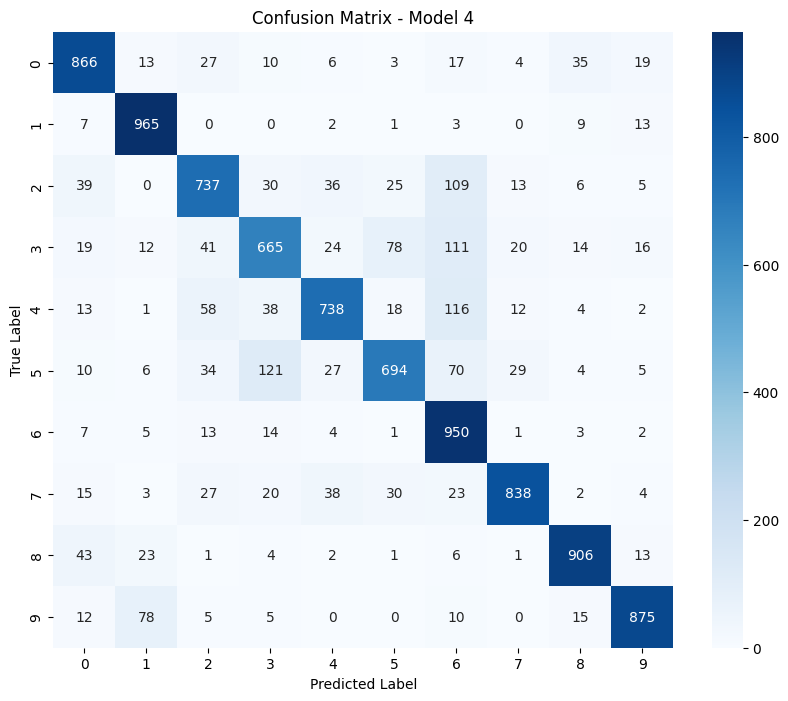

Classification Report - Model 4
              precision    recall  f1-score   support

    Airplane       0.84      0.87      0.85      1000
  Automobile       0.87      0.96      0.92      1000
        Bird       0.78      0.74      0.76      1000
         Cat       0.73      0.67      0.70      1000
        Deer       0.84      0.74      0.79      1000
         Dog       0.82      0.69      0.75      1000
        Frog       0.67      0.95      0.79      1000
       Horse       0.91      0.84      0.87      1000
        Ship       0.91      0.91      0.91      1000
       Truck       0.92      0.88      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000

--------------------------------------------------------------------------------
313/313 [==============================] - 1s 3ms/step


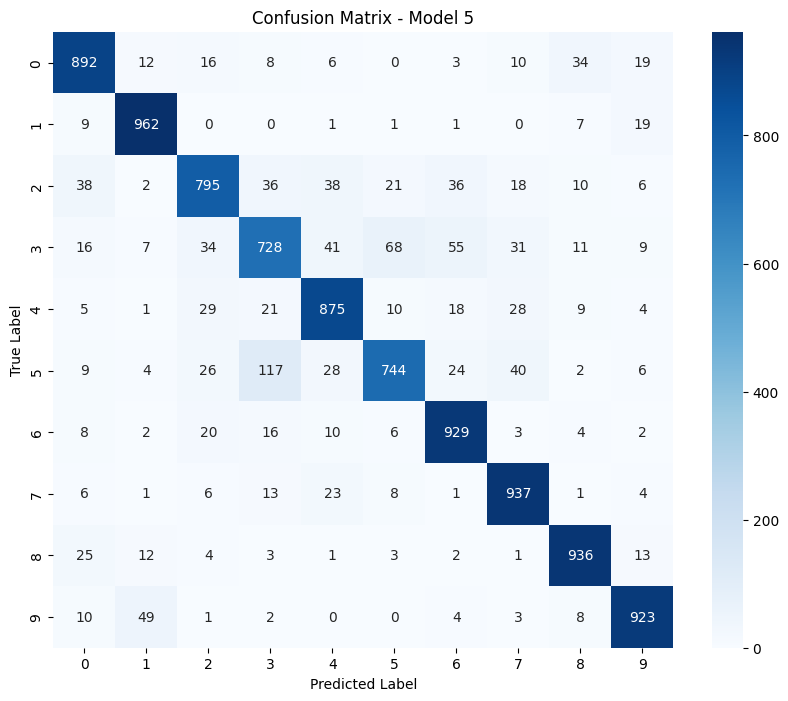

Classification Report - Model 5
              precision    recall  f1-score   support

    Airplane       0.88      0.89      0.88      1000
  Automobile       0.91      0.96      0.94      1000
        Bird       0.85      0.80      0.82      1000
         Cat       0.77      0.73      0.75      1000
        Deer       0.86      0.88      0.87      1000
         Dog       0.86      0.74      0.80      1000
        Frog       0.87      0.93      0.90      1000
       Horse       0.87      0.94      0.90      1000
        Ship       0.92      0.94      0.93      1000
       Truck       0.92      0.92      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

--------------------------------------------------------------------------------
313/313 [==============================] - 1s 3ms/step


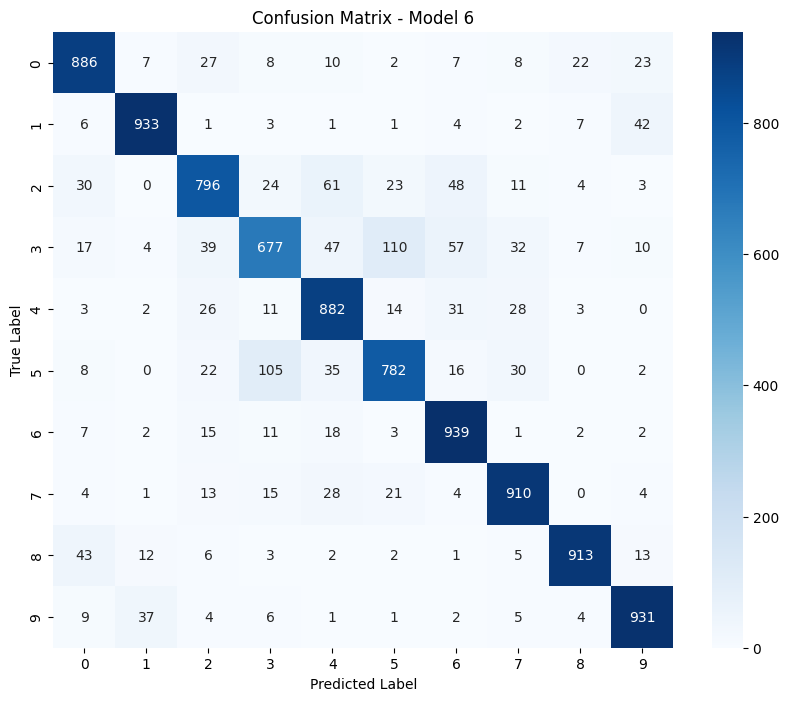

Classification Report - Model 6
              precision    recall  f1-score   support

    Airplane       0.87      0.89      0.88      1000
  Automobile       0.93      0.93      0.93      1000
        Bird       0.84      0.80      0.82      1000
         Cat       0.78      0.68      0.73      1000
        Deer       0.81      0.88      0.85      1000
         Dog       0.82      0.78      0.80      1000
        Frog       0.85      0.94      0.89      1000
       Horse       0.88      0.91      0.90      1000
        Ship       0.95      0.91      0.93      1000
       Truck       0.90      0.93      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

--------------------------------------------------------------------------------


In [ ]:

# CIFAR-10 class names
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Loop through all trained models
for i, model in enumerate(models, 1):
    # get predictions from all models
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    
    cm = confusion_matrix(y_true, y_pred_classes)

    # plot the confusion matrix for each model
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Model {i}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification Report for each model
    print(f"Classification Report - Model {i}")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    print("-" * 80)

### Confidence Bar for Each Class - Hyperparameter_Tuned CNN - (Model 5)

313/313 [==============================] - 1s 3ms/step


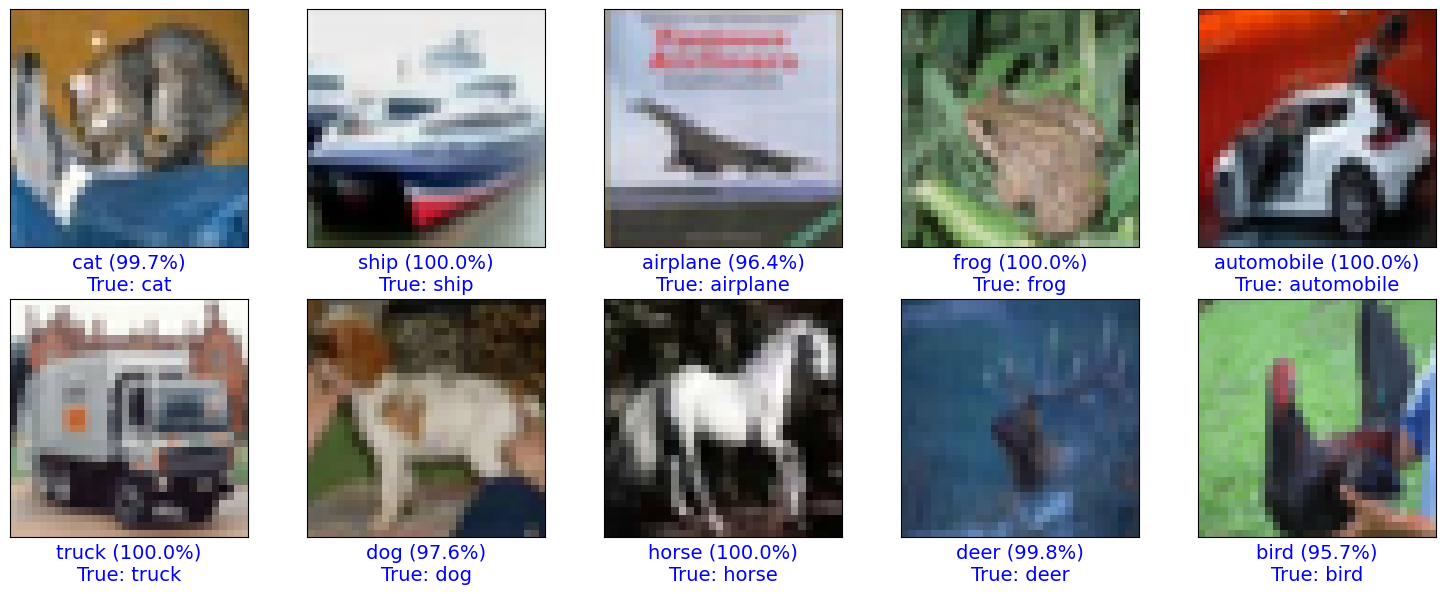

In [ ]:
# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get predictions from model_5
predictions = model_5.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_cat, axis=1)

# To find one correctly predicted image per class
selected_indices, seen = [], set()
for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)):
    if true == pred and true not in seen:
        selected_indices.append(i)
        seen.add(true)
    if len(seen) == 10:
        break

# Plot the images with confidence %
plt.figure(figsize=(15, 6))
for i, idx in enumerate(selected_indices):
    plt.subplot(2, 5, i + 1)
    img = x_test[idx]
    true = true_labels[idx]
    pred = predicted_labels[idx]
    conf = 100 * np.max(predictions[idx])
    color = 'blue' if pred == true else 'red'
    
    plt.imshow(img)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.xlabel(f"{class_names[pred]} ({conf:.1f}%)\nTrue: {class_names[true]}", color=color, fontsize=14)

plt.tight_layout()
plt.show()


## Confidence Bar Comparison
#### Model 1 = Hyperparameter-Tuned CNN model (Experiment 5)
#### Model 2 = TwoConv Deep CNN With Augmentation (Experiment 4)


313/313 [==============================] - 0s 1ms/step


C:\Users\BO\AppData\Local\Temp\ipykernel_21056\3518794591.py:52: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.15, right=0.95)
C:\Users\BO\AppData\Local\Temp\ipykernel_21056\3518794591.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


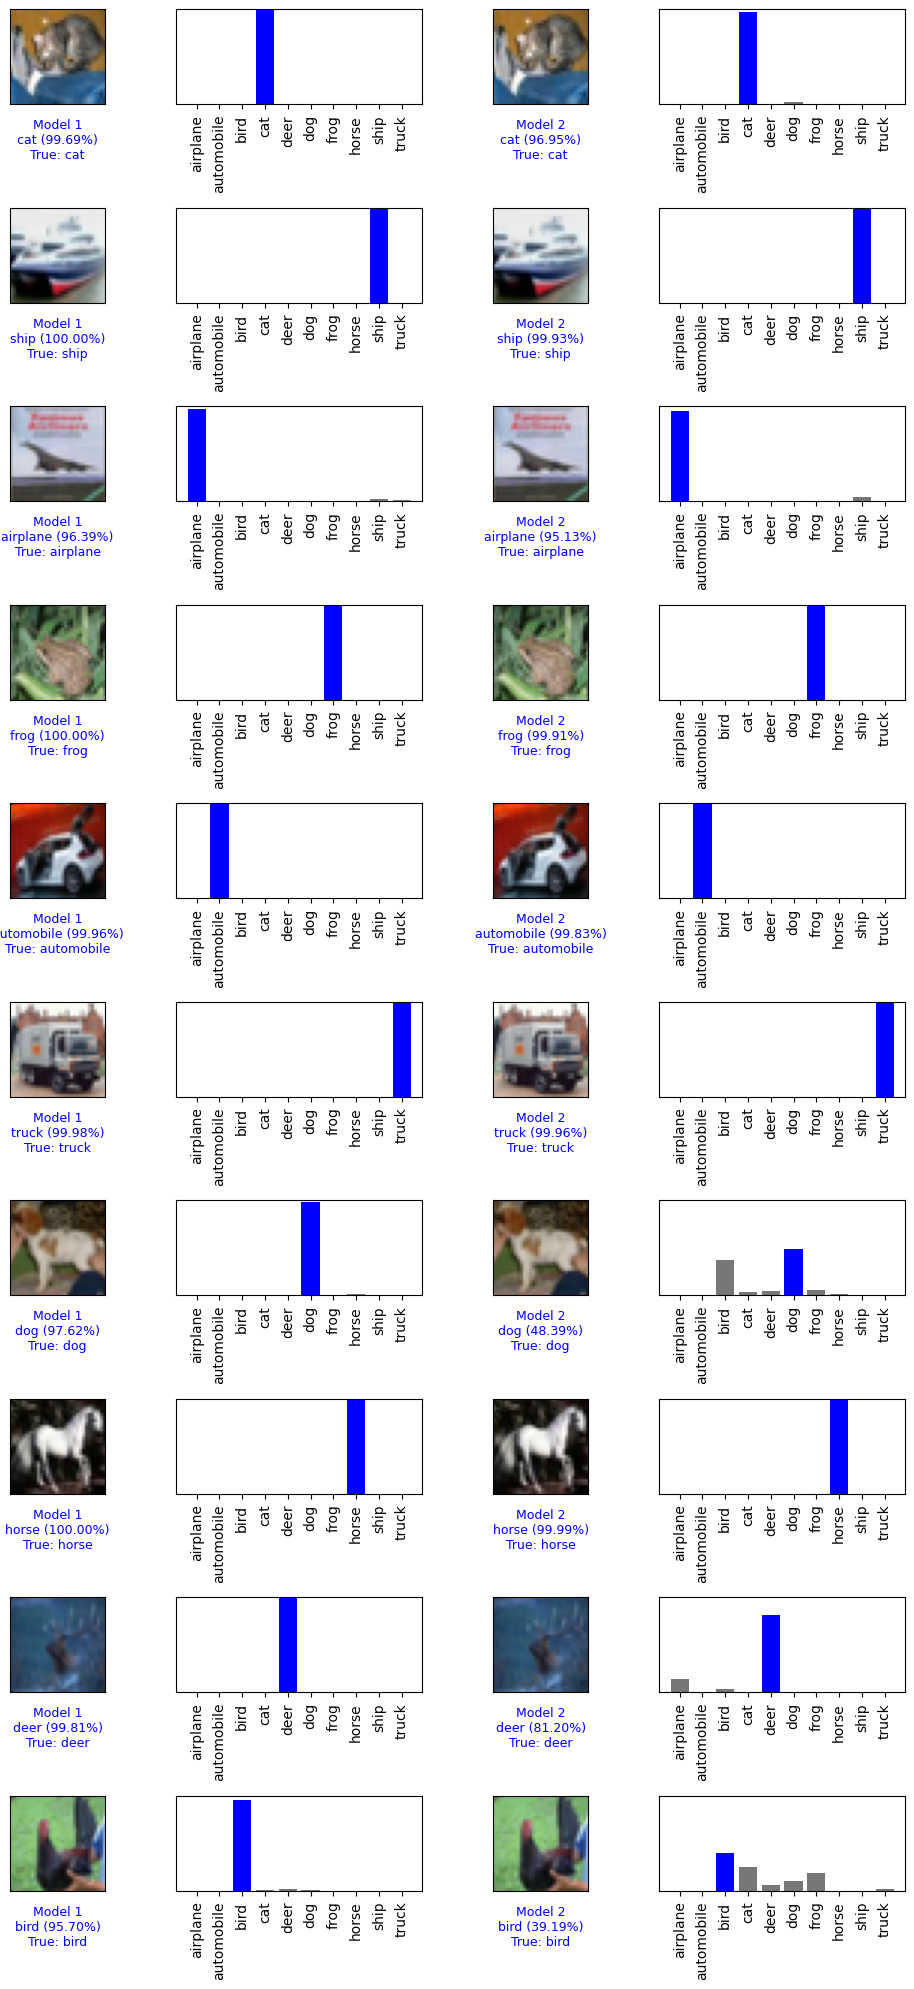

In [ ]:
# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# get predictions from model_5 and model_4
preds_1 = model_5.predict(x_test)
preds_2 = model_4.predict(x_test)
pred_labels_1 = np.argmax(preds_1, axis=1)
pred_labels_2 = np.argmax(preds_2, axis=1)
true_labels = np.argmax(y_test_cat, axis=1)

# To select one correctly predicted image per class
selected_indices, seen = [], set()
for i, (true, pred) in enumerate(zip(true_labels, pred_labels_1)):
    if true == pred and true not in seen:
        selected_indices.append(i)
        seen.add(true)
    if len(seen) == 10:
        break

# to plot model label, confidence % and true label
def plot_image(idx, preds, true_lbls, imgs, model_name):
    true, img = true_lbls[idx], imgs[idx]
    pred = np.argmax(preds)
    plt.imshow(img)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    color = 'blue' if pred == true else 'red'
    conf = 100 * np.max(preds)
    plt.xlabel(
        f"{model_name}\n{class_names[pred]} ({conf:.2f}%)\nTrue: {class_names[true]}",
        color=color, fontsize=9, labelpad=10
    )

# to plot confidence scores for all classes
def plot_confidence(idx, preds, true_lbls):
    true = true_lbls[idx]
    plt.bar(range(10), preds, color="#777777")
    plt.ylim(0, 1)
    plt.xticks(range(10), class_names, rotation=90)
    plt.yticks([])
    plt.grid(False)
    plt.bar(np.argmax(preds), preds[np.argmax(preds)], color='red')
    plt.bar(true, preds[true], color='blue')

# to compare predictions
plt.figure(figsize=(10, 20), constrained_layout=True)
for i, idx in enumerate(selected_indices):
    plt.subplot(10, 4, 4*i + 1)
    plot_image(idx, preds_1[idx], true_labels, x_test, "Model 1")
    plt.subplot(10, 4, 4*i + 2)
    plot_confidence(idx, preds_1[idx], true_labels)
    plt.subplot(10, 4, 4*i + 3)
    plot_image(idx, preds_2[idx], true_labels, x_test, "Model 2")
    plt.subplot(10, 4, 4*i + 4)
    plot_confidence(idx, preds_2[idx], true_labels)

plt.subplots_adjust(left=0.15, right=0.95)
plt.tight_layout()
plt.show()


### --- Image Prediction using Hyperparameter_Tuned CNN (Model 5) ---

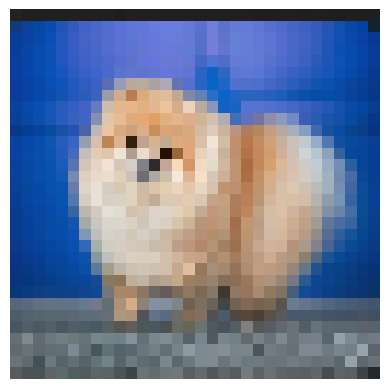

1/1 [==============================] - 0s 15ms/step
Predicted class: dog


In [ ]:
# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# load the image and resize
img = image.load_img('test_image.jpg', target_size=(32, 32))

# display the loaded image
plt.imshow(img)
plt.axis('off') 
plt.show()

# preprocessing image and predict the image class
img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)
predicted_class = np.argmax(model_5.predict(img_array)[0])

# print the predicted class name
print(f"Predicted class: {class_names[predicted_class]}")
